# Uczenie Maszynowe w Prognozowaniu Rynku Giełdowego

W tej prezentacji przyjrzymy się zastosowaniu modelu uczenia maszynowego, konkretniej głębokich sieci neuronowych, w prognozowaniu cen akcji na giełdach. Nasze dane będą pochodzić z serwisu Yahoo Finance. Jest to serwis, który zajmuję się informacjami giełdowymi, notowaniami akcji itp. Aby zaimportować dane do naszego programu wykorzystamy pakiet yfinance, który umożliwia w łatwy sposób pobranie odpowiednich danych finansowych wprost z serwisu Yahoo Finance. Importujemy dane dla 9 firm notowanych na dwóch największych gieładach w Stanach Zjednoczonych (NASDAQ - National Association of Securities Dealers Automated Quotations oraz NYSE - The New York Stock Exchange):

- AAPL (Apple Inc.): Jedna z największych firm technologicznych na świecie, znana z produktów takich jak iPhone, iPad, MacBook i Apple Watch. Zajmuje się także usługami cyfrowymi, jak Apple Music czy App Store.

- MSFT (Microsoft Corporation): Gigant technologiczny, znany przede wszystkim z systemu operacyjnego Windows oraz pakietu biurowego Office. Microsoft jest również aktywny w dziedzinie chmury obliczeniowej, gier komputerowych i innowacji technologicznych.

- GOOGL (Alphabet Inc.): Firma-matka Google'a, światowego lidera w dziedzinie wyszukiwania internetowego i reklam online. Alphabet to również inwestor w branżę technologiczną, zajmujący się projektami takimi jak Waymo (samochody autonomiczne) i DeepMind (sztuczna inteligencja).

- AMZN (Amazon.com, Inc.): Amazon to największy na świecie sprzedawca detaliczny online i platforma e-commerce. Oprócz handlu internetowego firma oferuje usługi w chmurze obliczeniowej (Amazon Web Services) oraz produkcję i dystrybucję treści multimedialnych.

- TSLA (Tesla, Inc.): Pionierska firma w dziedzinie elektrycznych pojazdów samochodowych, znana z produkcji samochodów elektrycznych, baterii, oprogramowania do autonomicznej jazdy oraz rozwiązań związanych z energią odnawialną.

- NVDA (NVIDIA Corporation): Firma specjalizująca się w zaawansowanych technologiach graficznych, takich jak karty graficzne dla graczy i profesjonalistów, systemy sztucznej inteligencji oraz technologie związane z obliczeniami w chmurze.

- JPM (JPMorgan Chase & Co.): Jedna z największych instytucji finansowych na świecie, działająca w obszarach bankowości inwestycyjnej, detalicznej i komercyjnej, zarządzaniu majątkiem oraz usługach bankowych dla firm.

- JNJ (Johnson & Johnson): Międzynarodowa firma farmaceutyczna i konsumencka, specjalizująca się w produkcji leków, wyrobów medycznych i artykułów higienicznych. Jest także znana z działalności w dziedzinie badań naukowych i innowacji medycznych.

- V (Visa Inc.): Jedna z największych na świecie firm płatniczych, dostarczająca technologie płatnicze i usługi transakcyjne dla firm, konsumentów i instytucji finansowych. Visa jest powszechnie używana do przetwarzania transakcji kartami płatniczymi na całym świecie.

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Ustawianie ziarna losowego
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


Na początku imporujemy potrzebne nam biblioteki:

- numpy to biblioteka wykorzystywana do obliczeń numerycznych,
- pandas to pakiet wykorzystywany do manipulacji, czyszczenia i analizy danych,
- yfinance to biblioteka, która pobiera dane finansowe z serwisu Yahoo Finance,
- matplotlib oraz seaborn to pakiety, które zapewniają narzędzia do tworzenia różnego rodzaju wykresów i wizualizacji danych,
- scikit-learn oraz tensorflow to pakiety wykorzystywane w uczeniu maszynowym oraz modelowaniu predykcyjnym.

Następnie tworzymy tabale, do której importujemy dane o wysokości cen zamknięcia dla wybranych 9 firm z okresu od 2010 do końca 2023 roku.

In [3]:
# Pobieranie danych dla wybranych spółek
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V']
data = {ticker: yf.download(ticker, start='2010-01-01', end='2023-12-31') for ticker in tickers}


# Tworzenie DataFrame zawierającego ceny zamknięcia dla wszystkich spółek
df = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA,JPM,JNJ,V
Date,,,,,,,,,
2010-01-04,7.643214,30.950001,15.684434,6.695000,NaN,4.622500,42.849998,64.680000,22.035000
2010-01-05,7.656429,30.959999,15.615365,6.734500,NaN,4.690000,43.680000,63.930000,21.782499
2010-01-06,7.534643,30.770000,15.221722,6.612500,NaN,4.720000,43.919998,64.449997,21.490000
2010-01-07,7.520714,30.450001,14.867367,6.500000,NaN,4.627500,44.790001,63.990002,21.690001
2010-01-08,7.570714,30.660000,15.065566,6.676000,NaN,4.637500,44.680000,64.209999,21.750000
...,...,...,...,...,...,...,...,...,...
2023-12-22,193.600006,374.579987,141.490005,153.419998,252.539993,488.299988,167.399994,155.460007,258.429993
2023-12-26,193.050003,374.660004,141.520004,153.410004,256.609985,492.790009,168.389999,156.139999,259.160004
2023-12-27,193.149994,374.070007,140.369995,153.339996,261.440002,494.170013,169.399994,156.350006,258.929993


Tworzymy wykres czasowy przedstawiający zmiany cen zamknięcia wybranych akcji na przestrzeni lat.

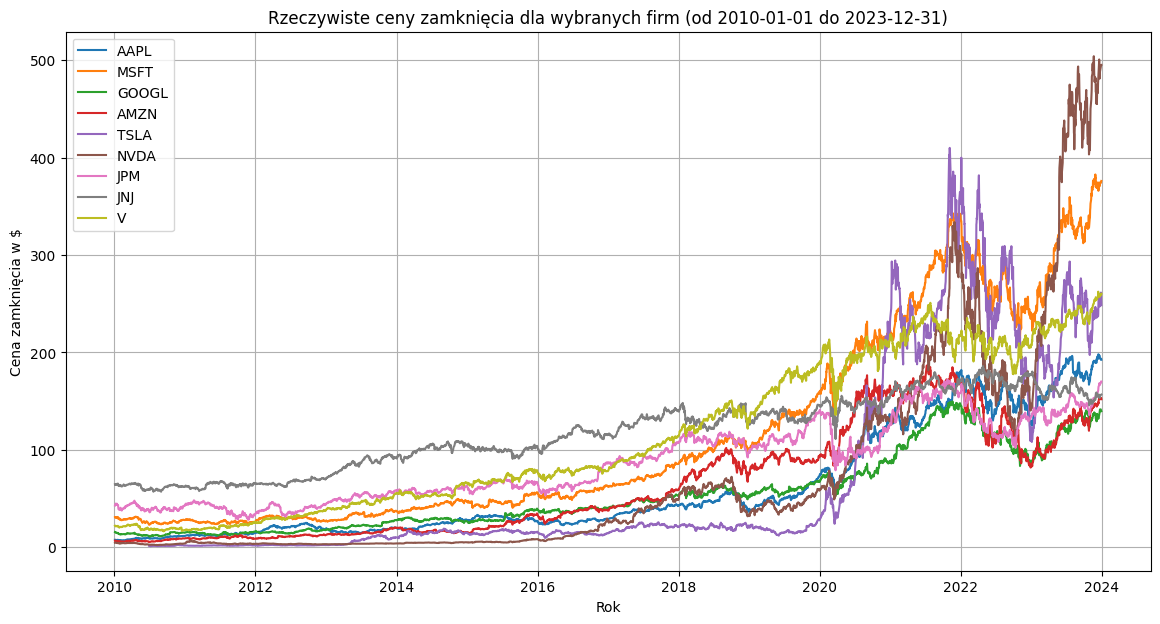

In [4]:
# Ustawienie rozmiaru wykresu
plt.figure(figsize=(14, 7))

# Wygenerowanie wykresu dla każdej spółki
for ticker in tickers:
    plt.plot(df.index, df[ticker], label=ticker)

# Dodanie tytułu i etykiet osi
plt.title('Rzeczywiste ceny zamknięcia dla wybranych firm (od 2010-01-01 do 2023-12-31)')
plt.xlabel('Rok')
plt.ylabel('Cena zamknięcia w $')
plt.legend()
plt.grid(True)
plt.show()

Na wykresie możemy zobaczyć, że przez ostatnie 3 lata ceny zamknięcia większości firm zanotowały duże wzrosty na przestrzeni rozwarzanych 13 lat. Przypada to głownie na okres w którym nasz model będzie testowany, co może skutkować tym, że nie nauczy się przewidywać szybkich, gwałtownych trendów i intensywnych wzrostów w przyszłości.

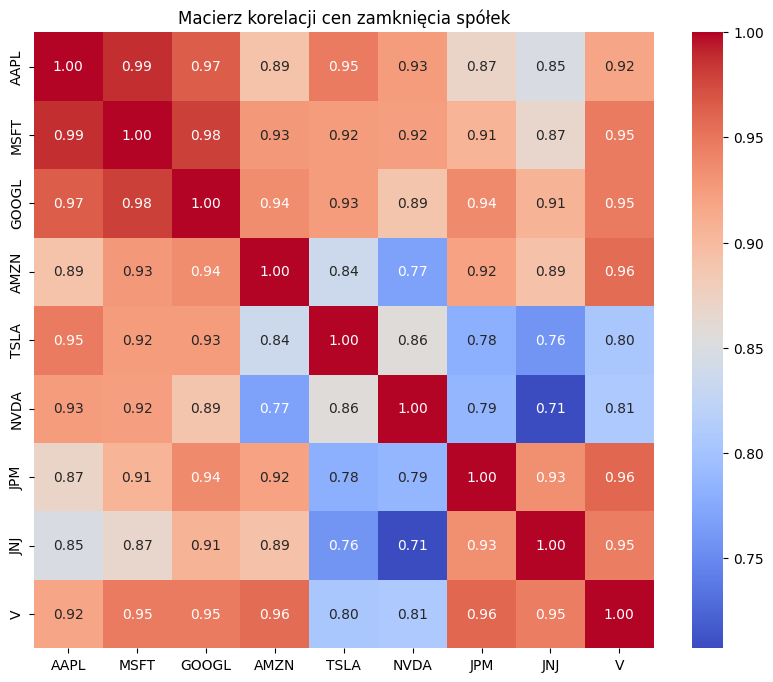

In [5]:
import seaborn as sns

# Wygenerowanie macierzy korelacji
corr_matrix = df.corr()

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(10, 8))

# Wygenerowanie graficznej macierzy korelacji za pomocą seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Dodanie tytułu wykresu
plt.title('Macierz korelacji cen zamknięcia spółek')

# Wyświetlenie wykresu
plt.show()

Wykonaliśmy wykres macierzy korelacji cen zamknięcia wybranych firm i możemy zuważyć, że wszyskie są dodatnio i mocno ze sobą skorelowane.

In [6]:
# Wyświetlenie liczby brakujących wartości w każdej kolumnie
print(df.isnull().sum())

# Usuwanie wierszy z brakującymi wartościami
df = df.dropna()

AAPL       0
MSFT       0
GOOGL      0
AMZN       0
TSLA     122
NVDA       0
JPM        0
JNJ        0
V          0
dtype: int64


Wyświetlamy ilość brakujących wartości. Możemy zobaczyc, że tylko w przypadku akcji Tesli występują braki w danych. Wynikają one z tego, że tesla dopiero w połowie 2010 roku weszła na giełde co możemy również zobaczyć na wykresie. Usuwamy te brakujące wartości, aby nie zaburzyć działania naszego modelu.

## Model LSTM

Przytępujemy do stworzenia modelu LSTM (Long Short-Term Memory). LSTM  to typ sieci neuronowej, zaprojektowany do przetwarzania i prognozowania danych sekwencyjnych oraz czasowych. LSTM jest szczególnie skuteczny w radzeniu sobie z problemem długoterminowej zależności w danych sekwencyjnych, który jest trudny do rozwiązania przez tradycyjne metody i modele.

In [7]:
# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
scaled_data = pd.DataFrame(scaled_data, columns=df.columns)

# Tworzenie sekwencji danych
sequence_length = 60  # Optymalna długość sekwencji

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequences = create_sequences(scaled_data.values, sequence_length)
X = sequences[:, :-1, :]
y = sequences[:, -1, :len(tickers)]

# Podział danych na zestawy treningowe i testowe uwzględniając porządek czasowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Normalizujemy dane, czyli przekształcamy wartości aby mieściły się w przedziale [0, 1]. Ma to kluczowe znaczenie dla algorytmów uczenia maszynowego, szczególnie sieci neuronowych, ponieważ przyspiesza konwergencję modelu i pomaga w stabilności treningu.

Tworzymy sekwencje danych: W tym przypadku, sekwencja o długości 60 oznacza, że model będzie wykorzystywał dane z ostatnich 60 dni do przewidywania wartości na dzień 61. Tworzenie sekwencji jest kluczowe dla modeli typu LSTM (Long Short-Term Memory).

Następnie przygotowujemy dane wejściowe i wyjściowe. Dzielimy je na zestaw treningowy oraz testowy. Podział danych na zestaw treningowy (80%) i testowy (20%) zapewnia, że model jest trenowany na jednej części danych, a testowany na innej, wcześniej niewidzianej części.

In [8]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=len(tickers)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


C:\Users\Lukasz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 59, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,659 (127.57 KB)

 Trainable params: 32,659 (127.57 KB)

 Non-trainable params: 0 (0.00 B)

Model składa się z dwóch warstw LSTM zdolnych do przechowywania długoterminowych zależności w danych sekwencyjnych, z warstwami Dropout (to warstwy regularizacyjne, które losowo wyłączają 20% (0.2) jednostek w trakcie treningu, aby zapobiegać przeuczeniu modelu). Na końcu jest warstwa Dense, która dokonuje predykcji cen. Model jest kompilowany z użyciem optymalizatora Adam i funkcji straty średniego błędu kwadratowego (MSE). W tabelce jest wypisana liczba parametrów w każdej warstwie a na końcu jest obliczona ich suma.

Trenowanie modelu LSTM przy użyciu danych treningowych i walidacyjnych.

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0201 - val_loss: 0.0347
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0041 - val_loss: 0.0281
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0031 - val_loss: 0.0256
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0025 - val_loss: 0.0268
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021 - val_loss: 0.0286
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0019 - val_loss: 0.0209
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017 - val_loss: 0.0217
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0015 - val_loss: 0.0212
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0015 - val_loss: 0.0207
Epoch 10/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0013 - val_loss: 0.0197
Epoch 11/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0013 - val_loss: 0.0189
Epoch 12/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0

 Następnie generowany jest wykres, na którym wyświetlane są wartości straty (loss) dla danych treningowych i walidacyjnych w każdej epoce.

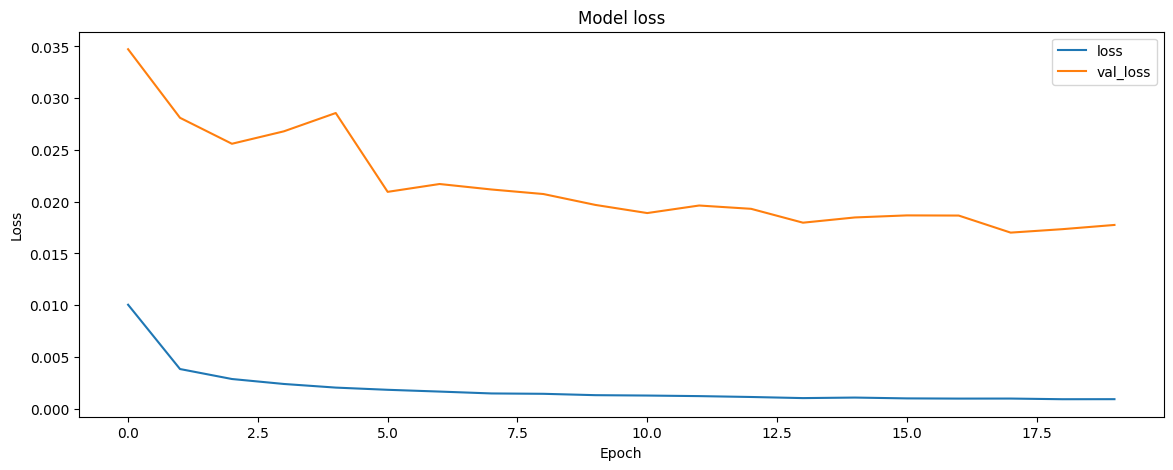

In [10]:
# Wykres uczenia
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Pierwsze kilka epok charakteryzuje się znacznym spadkiem wartości funkcji straty, co sugeruje, że model szybko się uczy i dostosowuje do danych treningowych.  Po kilku początkowych epokach wartości funkcji straty stabilizują się i utrzymują mniej więcej na równym poziomie. To sugeruje, że model przestał znacząco poprawiać swoje wyniki i osiągnął punkt, w którym dalsze trenowanie nie przynosi już dużych korzyści

 Przewidujemy ceny zamknięcia na zbiorze testowym za pomocą wytrenowanego modelu LSTM, a następnie wykonujemy odwrócenie skalowania, aby otrzymać rzeczywiste wartości cen zamknięcia. Następnie obliczamy pierwiastek z błądu średniokwadratowego (RMSE) oraz średni błąd bezwzględny (MAE) dla każdej spółki i wyświetlamy wyniki.

In [22]:
# Przewidywanie na zbiorze testowym
predictions = model.predict(X_test)

# Inwersja skalowania tylko dla kolumn cen zamknięcia
predictions_inversed = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - predictions.shape[1])))))[:, :len(tickers)]
y_test_inversed = scaler.inverse_transform(np.hstack((y_test, np.zeros((y_test.shape[0], scaled_data.shape[1] - y_test.shape[1])))))[:, :len(tickers)]

# Obliczanie RMSE dla każdej spółki
for i, ticker in enumerate(tickers):
    rmse = np.sqrt(mean_squared_error(y_test_inversed[:, i], predictions_inversed[:, i]))
    mae = median_absolute_error(y_test_inversed[:, i], predictions_inversed[:, i])
    print(f'RMSE dla {ticker}: {rmse}, MAE dla {ticker}: {mae}')


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE dla AAPL: 21.330181137685166, MAE dla AAPL: 17.67308230963104
RMSE dla MSFT: 42.11794722565566, MAE dla MSFT: 32.422117678217674
RMSE dla GOOGL: 13.245048986727898, MAE dla GOOGL: 11.55339789709356
RMSE dla AMZN: 33.63802349339826, MAE dla AMZN: 30.18580921321768
RMSE dla TSLA: 25.02819643665424, MAE dla TSLA: 14.664803414818607
RMSE dla NVDA: 138.34712453502837, MAE dla NVDA: 67.8207226828826
RMSE dla JPM: 10.0539541324437, MAE dla JPM: 7.922851088149173
RMSE dla JNJ: 5.455259018201065, MAE dla JNJ: 4.384691104240119
RMSE dla V: 14.262187880461186, MAE dla V: 10.254310712566735


RMSE mierzy średnią wartość błędu predykcji modelu dla danej spółki. Im niższy RMSE, tym lepsza jakość predykcji. Możemy dzięki temu ocenić jakość naszych przewidywań i określić o ile nasze przewidywane ceny mogą różnić się od tych rzeczywistych, na przyklad jeśli RMSE dla spółki AAPL wynosi około 10, oznacza to, że średnio model przewiduje cenę zamknięcia z błędem rzędu 10 dolarów. MAE ocenia średnią wielkość błędów w prognozach, ignorując kierunek błędów (czy są dodatnie, czy ujemne).  Podobnie jak w przypadku RMSE im niższa wartość MAE, tym lepszy model, ponieważ wskazuje to na mniejszą średnią różnicę między przewidywanymi, a rzeczywistymi wartościami.

Następie wykonaliśmy wizualizacje na wykresie, która pokaże nam rzeczysiste i prognozowane cenny akcji na przestrzeni lat pochodzących z okresu na którym testowny był model, aby można je było łatwo porównać.

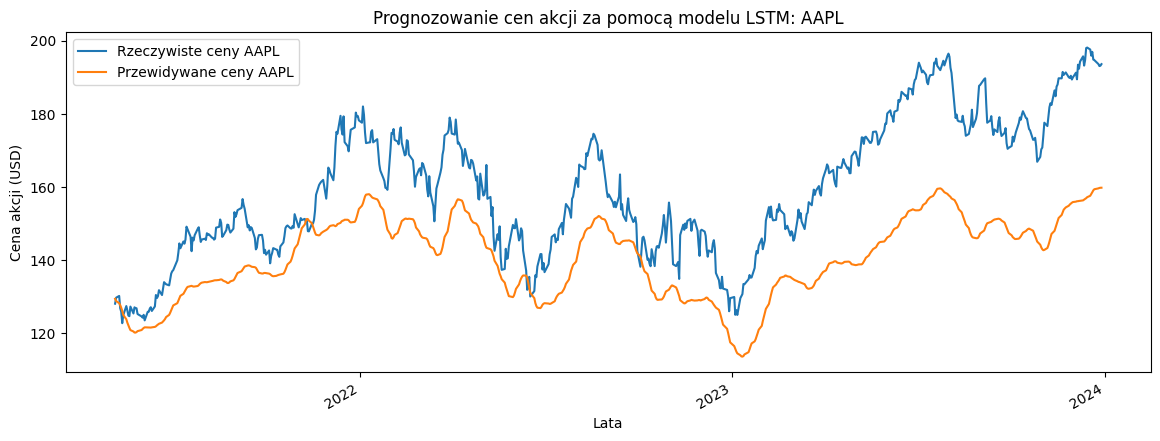

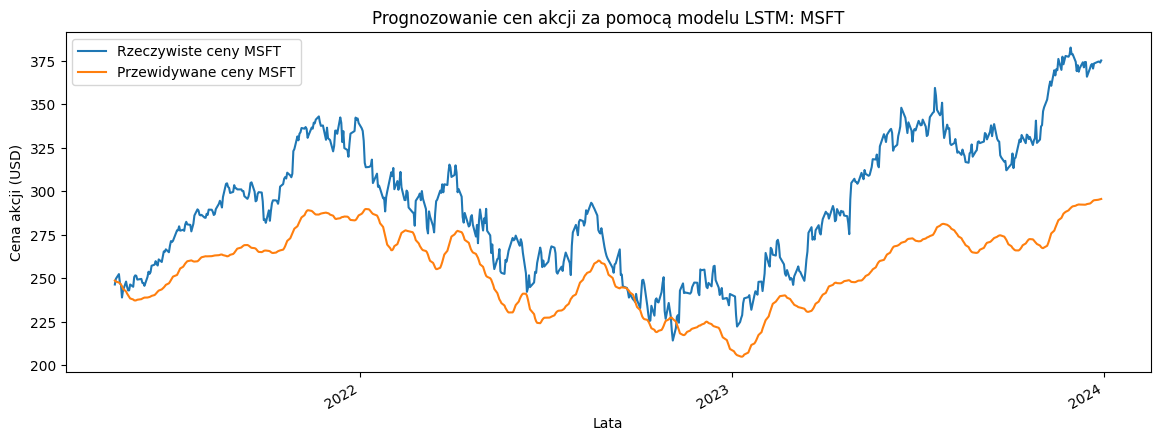

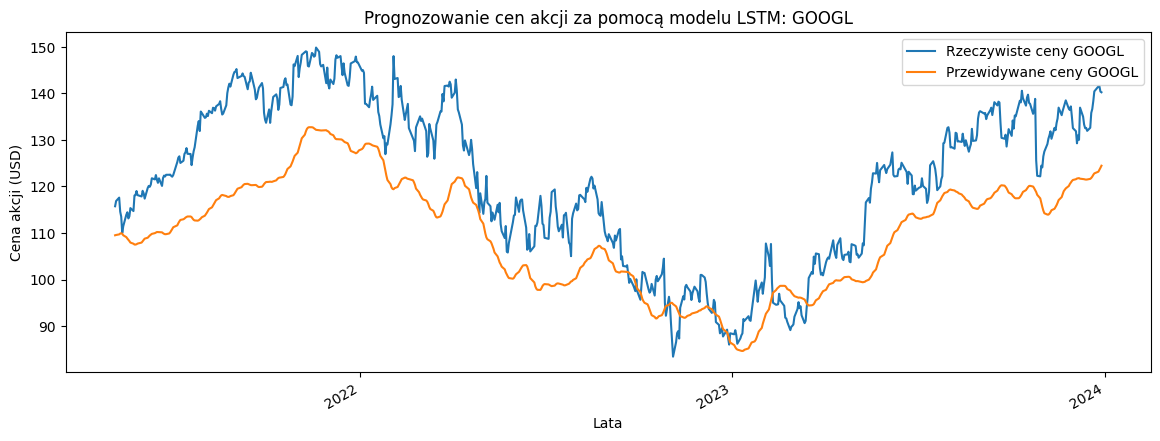

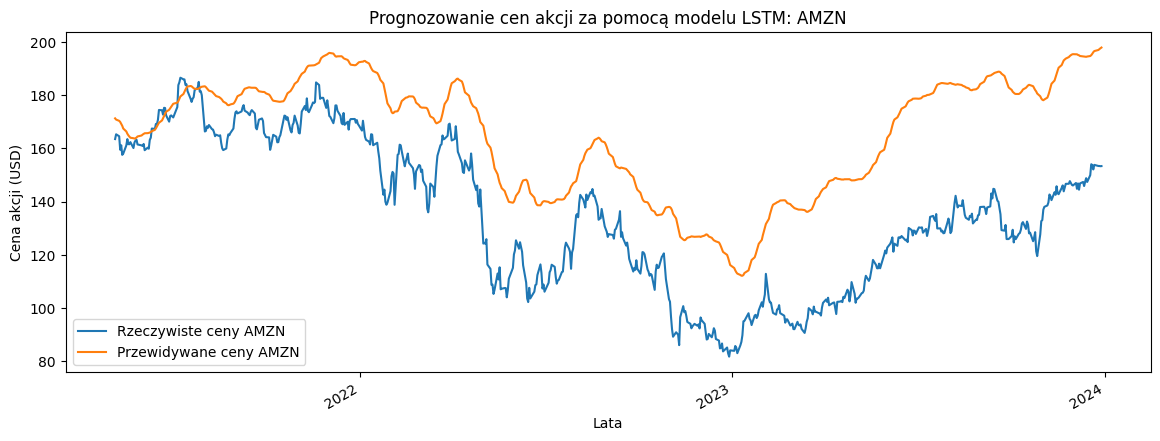

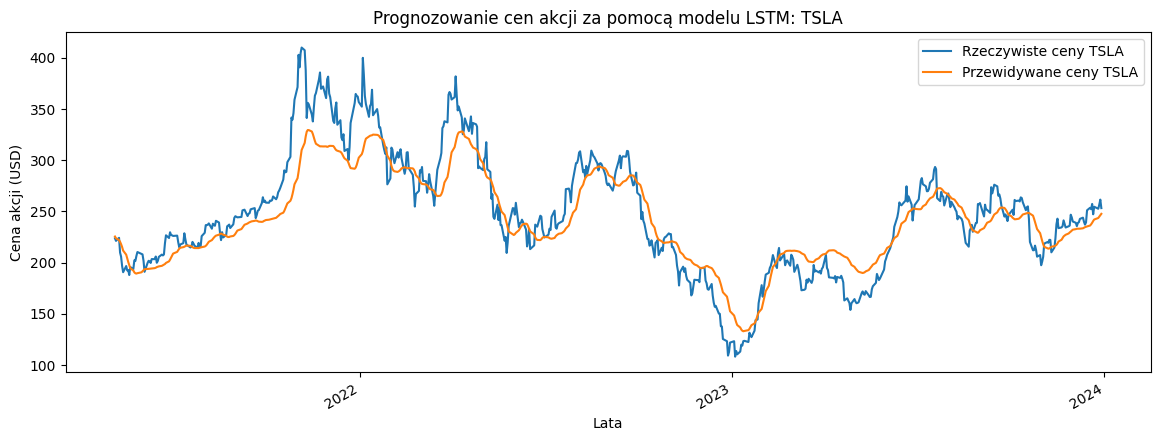

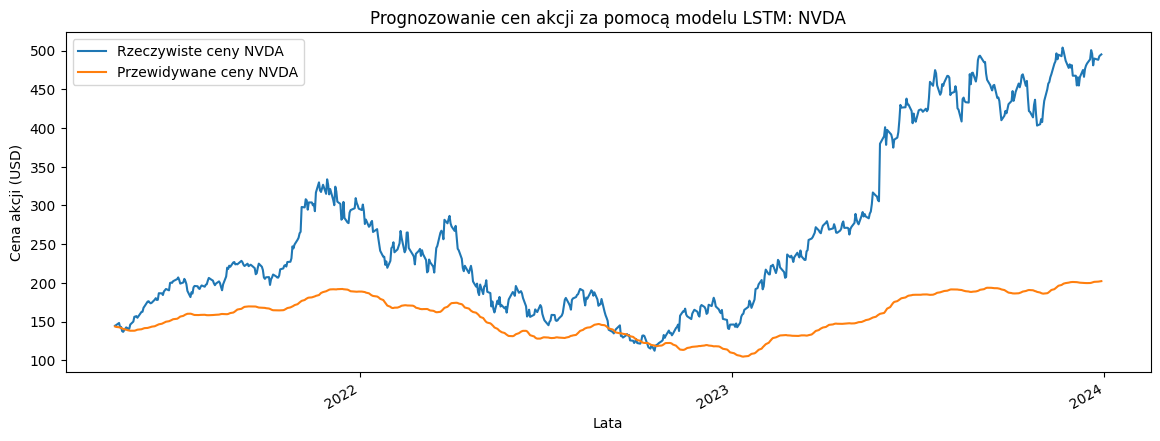

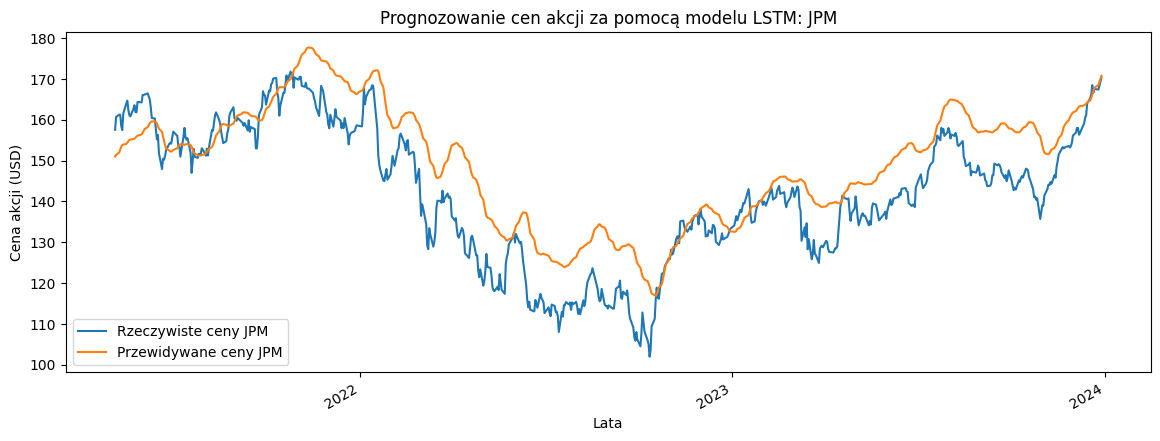

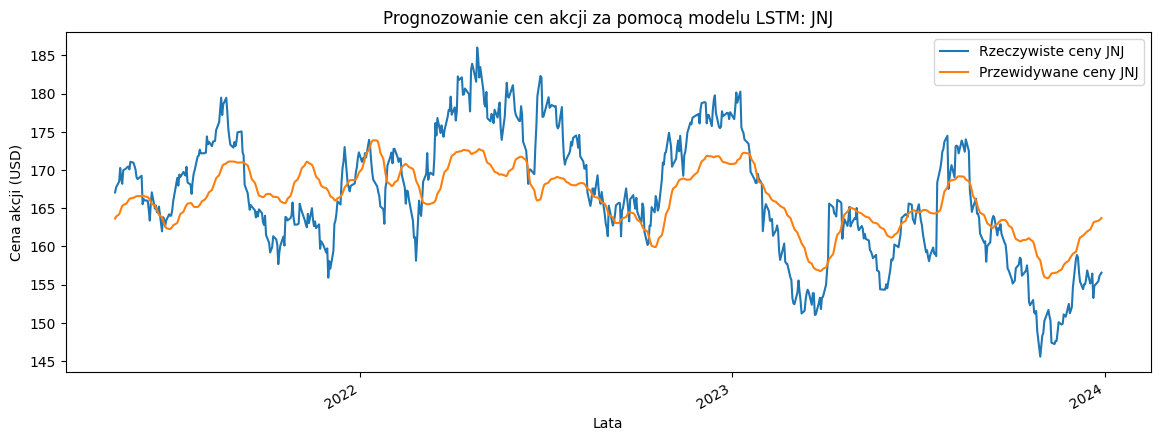

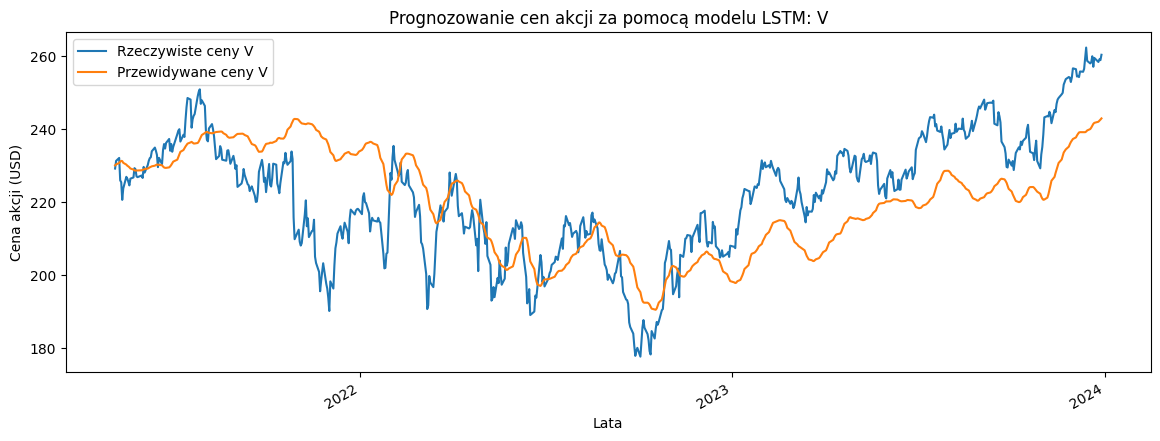

In [12]:
# Przygotowanie danych do wykresu
test_dates = df.index[split + sequence_length:]

for i, ticker in enumerate(tickers):
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_test_inversed[:, i], label=f'Rzeczywiste ceny {ticker}')
    plt.plot(test_dates, predictions_inversed[:, i], label=f'Przewidywane ceny {ticker}')
    plt.title(f'Prognozowanie cen akcji za pomocą modelu LSTM: {ticker}')
    plt.xlabel('Lata')
    plt.ylabel('Cena akcji (USD)')
    plt.legend()

    # Formatowanie osi X
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    plt.gcf().autofmt_xdate()

    plt.show()


Możemy zobaczyć ogólną tendencje do niedoszacowywania cen akcji firm, które notowały szybkie i wysokie wsrosty. Największe różnice między rzeczywistymi, a przewidywanymi wartościami cen możemy zobserwować w przpadku akcji Nvidi, która na przestrzeni lat w których testowaliśmy model zanotowała największe wzrosty spośród zestawianych tutaj spółek, bo aż o ponad 400%. Przy cenach akcji notujących powolniejsze, ale stałe wzrosty takich jak Google czy Visa model radził sobie dużo lepiej z przewidywaniem. W przypadku akcji JPM, które notowały małe wzrosty oraz akcji Amazona, które na przestrzeni badanych lat zanotowaly strate model przeszacował ich ceny.